In [16]:
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
import warnings

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

# # Boruta
# USE_BORUTA = False
# if USE_BORUTA:
#     from boruta import BorutaPy

# Top features to select
TOP_N = 50


In [17]:
# Load data
df = pd.read_csv("Final_df.csv")
df = df.drop(df.columns[0], axis=1)

# Load protein mapping
protein_name = pd.read_csv("SomalogicAnalyteInfoV1_anonymized.csv", engine="python", on_bad_lines="skip")
protein_name.columns = protein_name.columns.str.strip()
protein_name = protein_name.apply(lambda col: col.str.strip() if col.dtype=='object' else col)

# Keep human proteins only
protein_name = protein_name[(protein_name["organism"].str.lower()=="human") & (protein_name["type"].str.lower()=="protein")].reset_index(drop=True)

# Keep columns that exist in both datasets
meta_cols = ["contributor_code","sample_id","visit","age_at_visit","computed_age_range", "sex","is_neuropath","is_biomarker","pd","sample_matrix","sample_type"]

cols_to_keep = meta_cols + protein_name["column_name"].tolist()
df = df[df.columns.intersection(cols_to_keep)]

# Protein seq columns
seq_cols = [col for col in df.columns if col.startswith("seq_")]

# Features & target
X_full = df[seq_cols]
y = df["pd"]

In [18]:
# def select_rf_features(X, y, top_n=TOP_N):
#     model = RandomForestClassifier(n_estimators=500, random_state=62, n_jobs=-1)
#     model.fit(X, y)
#     imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
#     return imp.head(top_n).index.tolist()


In [19]:
def select_lgb_features(X, y, top_n=TOP_N):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*LightGBM.*")

        model = lgb.LGBMClassifier(n_estimators=800, random_state=62, n_jobs=-1, verbosity=-1)
        model.fit(X, y)
    imp = pd.Series(model.booster_.feature_importance(importance_type='gain'),
                    index=X.columns).sort_values(ascending=False)
    return imp.head(top_n).index.tolist()


In [ ]:
# def select_xgb_features(X, y, top_n=TOP_N):
#     model = XGBClassifier(n_estimators=500, eval_metric='logloss',
#                           learning_rate=0.05, random_state=62, n_jobs=-1, verbosity=0)
#     model.fit(X, y)
#     imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
#     return imp.head(top_n).index.tolist()


In [ ]:
# def select_extra_trees_features(X, y, top_n=TOP_N):
#     model = ExtraTreesClassifier(n_estimators=500, random_state=62, n_jobs=-1)
#     model.fit(X, y)
#     imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
#     return imp.head(top_n).index.tolist()


In [ ]:
# def select_lasso_features(X, y, top_n=TOP_N):
#     model = LogisticRegression(penalty='l1', solver='liblinear', random_state=62)
#     model.fit(X, y)
#     coef = pd.Series(abs(model.coef_[0]), index=X.columns).sort_values(ascending=False)
#     return coef.head(top_n).index.tolist()


In [ ]:
# def select_boruta_features(X, y, top_n=TOP_N):
#     rf = RandomForestClassifier(n_estimators=500, random_state=62, n_jobs=-1)
#     boruta = BorutaPy(rf, n_estimators='auto', random_state=62)
#     boruta.fit(X.values, y.values)
#     selected = X.columns[boruta.support_].tolist()
#     return selected[:top_n]


In [20]:
import os
import datetime
import joblib
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb
from lightgbm import early_stopping, record_evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report
)


def train_evaluate_lgb_with_plots(X, y, show_plots=True, figsize=(12, 10), save_model=True, out_dir="models"):
    
    os.makedirs(out_dir, exist_ok=True)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Scale
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    # LightGBM params
    params = {
        "objective": "binary",
        "learning_rate": 0.01,
        "num_leaves": 31,
        "feature_fraction": 0.8,
        "bagging_fraction": 0.8,
        "bagging_freq": 5,
        "n_estimators": 2000,
        "random_state": 42,
        "n_jobs": -1,
        "verbosity": -1,
    }

    # Prepare to record evaluation results
    evals_result = {}

    model = lgb.LGBMClassifier(**params)

    # Request both AUC and binary_logloss to be evaluated & recorded
    eval_metrics = ["auc", "binary_logloss"]

    # Fit with record_evaluation and early stopping
    model.fit(
        X_train_s, y_train,
        eval_set=[(X_train_s, y_train), (X_test_s, y_test)],
        eval_metric=eval_metrics,
        callbacks=[early_stopping(stopping_rounds=100), record_evaluation(evals_result)]
    )

    # Predictions & basic metrics
    probs = model.predict_proba(X_test_s)[:, 1]
    preds = (probs >= 0.5).astype(int)

    metrics = {
        "AUC": roc_auc_score(y_test, probs),
        "ACC": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds, zero_division=0),
        "Recall": recall_score(y_test, preds, zero_division=0),
        "F1": f1_score(y_test, preds, zero_division=0)
    }

    # Confusion matrix and classification report
    conf_matrix = confusion_matrix(y_test, preds)
    class_report = classification_report(y_test, preds, zero_division=0)

    # Save model & scaler if requested
    saved_paths = {}
    if save_model:
        ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        model_path = os.path.join(out_dir, f"lgb_model_{ts}.pkl")
        scaler_path = os.path.join(out_dir, f"scaler_{ts}.pkl")
        try:
            joblib.dump(model, model_path)
            joblib.dump(scaler, scaler_path)
            saved_paths = {"model": model_path, "scaler": scaler_path}
        except Exception as e:
            print(f"Warning: could not save model/scaler to disk: {e}")
            saved_paths = {}

    # --- Plotting ---
    if show_plots:
        # Helper to pick metric series safely
        def get_series(evals, dataset_name_candidates, metric_name):
            for ds in dataset_name_candidates:
                if ds in evals and metric_name in evals[ds]:
                    return np.array(evals[ds][metric_name], dtype=float)
            return None

        ds_names = list(evals_result.keys())
        train_key = 'training' if 'training' in evals_result else (ds_names[0] if ds_names else None)
        val_key = None
        for k in ds_names:
            if k != train_key and ('valid' in k or 'valid_' in k or 'valid' == k):
                val_key = k
                break
        if val_key is None:
            val_key = ds_names[1] if len(ds_names) > 1 else None

        train_auc = get_series(evals_result, [train_key], 'auc') if train_key else None
        val_auc   = get_series(evals_result, [val_key], 'auc') if val_key else None

        train_loss = get_series(evals_result, [train_key], 'binary_logloss') if train_key else None
        val_loss   = get_series(evals_result, [val_key], 'binary_logloss') if val_key else None

        # Main 2x2 figure
        plt.figure(figsize=figsize)

        # 1) AUC over boosting iterations
        plt.subplot(2, 2, 1)
        plotted_any = False
        if train_auc is not None:
            plt.plot(train_auc, label=f"Train AUC ({train_key})")
            plotted_any = True
        if val_auc is not None:
            plt.plot(val_auc, label=f"Valid AUC ({val_key})")
            plotted_any = True
        if plotted_any:
            plt.title("AUC vs Iterations")
            plt.xlabel("Iteration")
            plt.ylabel("AUC")
            plt.legend()
            plt.grid(alpha=0.3)
        else:
            plt.text(0.5, 0.5, "No AUC logged", ha='center', va='center')
            plt.axis('off')

        # 2) Loss over boosting iterations
        plt.subplot(2, 2, 2)
        plotted_any = False
        if train_loss is not None:
            plt.plot(train_loss, label=f"Train Loss ({train_key})")
            plotted_any = True
        if val_loss is not None:
            plt.plot(val_loss, label=f"Valid Loss ({val_key})")
            plotted_any = True
        if plotted_any:
            plt.title("Binary Logloss vs Iterations")
            plt.xlabel("Iteration")
            plt.ylabel("Binary Logloss")
            plt.legend()
            plt.grid(alpha=0.3)
        else:
            plt.text(0.5, 0.5, "No binary_logloss logged", ha='center', va='center')
            plt.axis('off')

        # 3) ROC curve (test set)
        plt.subplot(2, 2, 3)
        fpr, tpr, _ = roc_curve(y_test, probs)
        roc_auc = roc_auc_score(y_test, probs)
        plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.4f})")
        plt.plot([0, 1], [0, 1], linestyle='--', alpha=0.6)
        plt.title("ROC curve (Test set)")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.grid(alpha=0.3)

        # 4) Precision-Recall curve
        plt.subplot(2, 2, 4)
        precision, recall, _ = precision_recall_curve(y_test, probs)
        ap = average_precision_score(y_test, probs)
        plt.plot(recall, precision, label=f"PR (AP = {ap:.4f})")
        plt.title("Precision-Recall (Test set)")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend()
        plt.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Confusion Matrix plot (separate figure)
        cm = conf_matrix
        plt.figure(figsize=(5, 4))
        im = plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion Matrix (Test set)")
        plt.colorbar(im, fraction=0.046, pad=0.04)
        tick_marks = np.arange(len(np.unique(y)))
        # If y has labels other than 0/1, we still want correct ticks
        plt.xticks([0, 1], ["Healthy", "PD"])
        plt.yticks([0, 1], ["Healthy", "PD"])

        # annotate cells
        thresh = cm.max() / 2.0 if cm.max() != 0 else 0.5
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                         ha="center", va="center",
                         color="white" if cm[i, j] > thresh else "black")
        plt.ylabel("True label")
        plt.xlabel("Predicted label")
        plt.tight_layout()
        plt.show()

    # Print the classification report and confusion matrix for immediate feedback
    print("=== Classification Report (Test set) ===")
    print(class_report)
    print("=== Confusion Matrix (rows=true labels, cols=predicted labels) ===")
    print(conf_matrix)

    return metrics, evals_result, model, scaler, conf_matrix, class_report, saved_paths



=== LightGBM Feature Selection ===
Top features: ['seq_6941_11', 'seq_2585_2', 'seq_10967_12', 'seq_12715_30', 'seq_14254_27', 'seq_18821_9', 'seq_5478_50', 'seq_10663_42', 'seq_3204_2', 'seq_6918_183', 'seq_21526_88', 'seq_18859_7', 'seq_10562_42', 'seq_15640_54', 'seq_11105_171', 'seq_19496_1', 'seq_3434_34', 'seq_14337_1', 'seq_12387_7', 'seq_5661_15', 'seq_4982_54', 'seq_24707_6', 'seq_18382_109', 'seq_21153_5', 'seq_14023_84', 'seq_19347_37', 'seq_20161_41', 'seq_6342_10', 'seq_23371_5', 'seq_4542_24', 'seq_21961_14', 'seq_21477_105', 'seq_12549_33', 'seq_12684_5', 'seq_5701_81', 'seq_16892_23', 'seq_5009_11', 'seq_5601_2', 'seq_25452_16', 'seq_9366_54', 'seq_25501_128', 'seq_17761_2', 'seq_4131_72', 'seq_20187_10', 'seq_6334_9', 'seq_16074_12', 'seq_6225_3', 'seq_7215_18', 'seq_5011_11', 'seq_4891_50']
Mapped protein targets: ['NETO2', 'INSI1', 'PRL', 'PTGD2', 'ADSV', 'DCP1B', 'PTN4', 'TPPC3', 'TAGL', 'GRB2-related adapter protein 2', 'ENPP2', 'NUDT5', 'Catechol O-methyltransfer

d:\Punjab Engineering College\Semester Work\sem 7\Major_project\GNPC Harmonised Dataset v1\Clinical\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


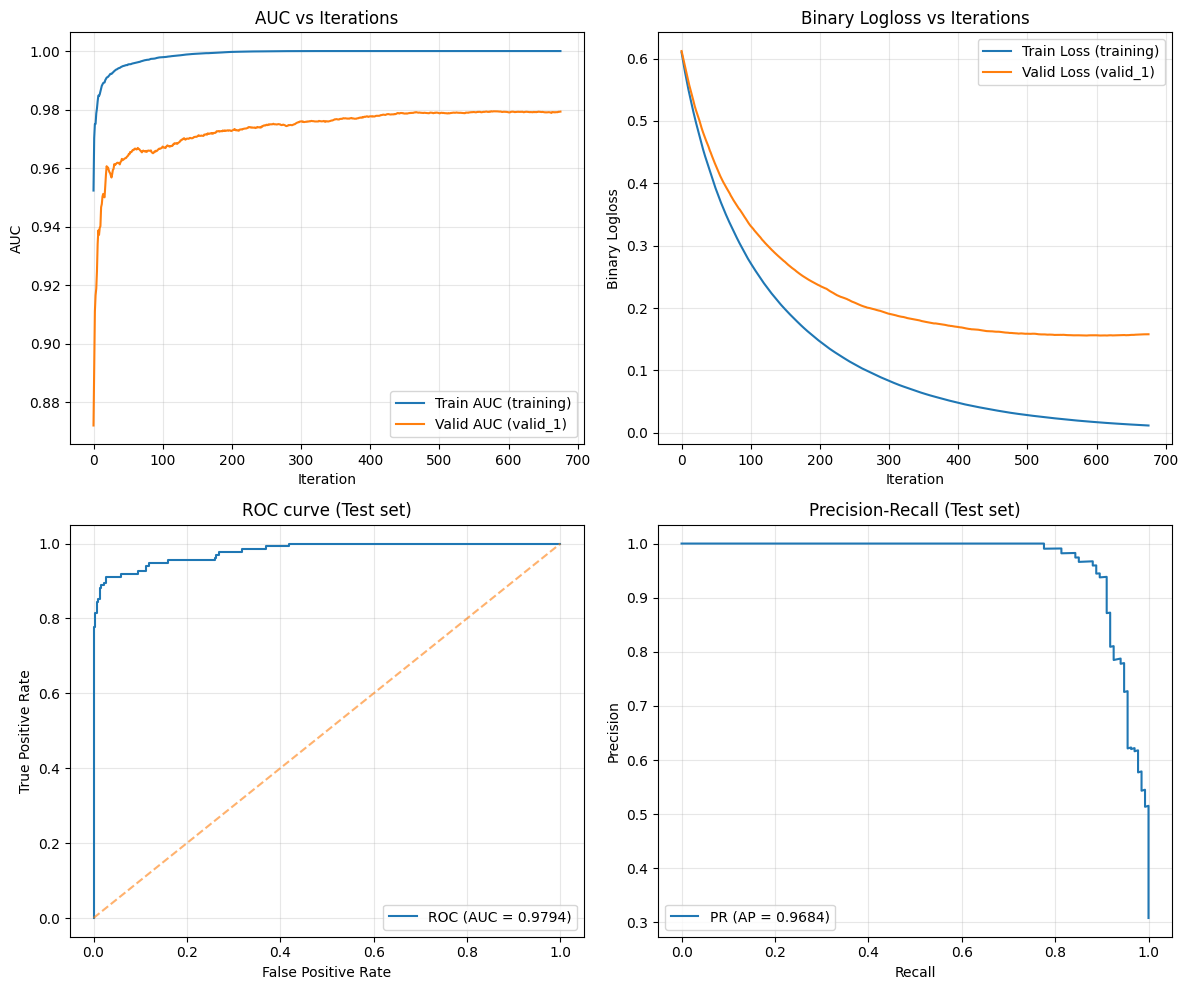

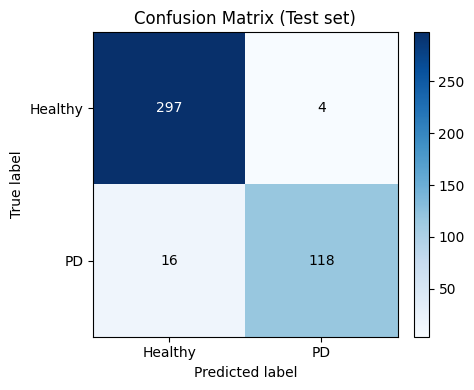

=== Classification Report (Test set) ===
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       301
           1       0.97      0.88      0.92       134

    accuracy                           0.95       435
   macro avg       0.96      0.93      0.94       435
weighted avg       0.95      0.95      0.95       435

=== Confusion Matrix (rows=true labels, cols=predicted labels) ===
[[297   4]
 [ 16 118]]
Top feature importances for LightGBM:
 seq_6941_11     944
seq_3204_2      733
seq_6918_183    555
seq_20161_41    512
seq_18859_7     506
seq_2585_2      452
seq_15640_54    450
seq_4982_54     444
seq_19347_37    435
seq_12549_33    435
dtype: int32


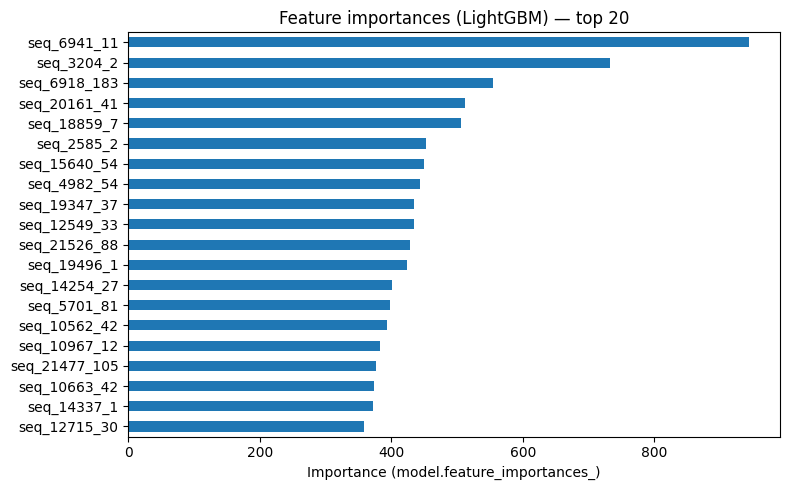

Feature importance plot saved to: fi_plots\fi_LightGBM.png
Classification report saved to: models\class_report_LightGBM.txt


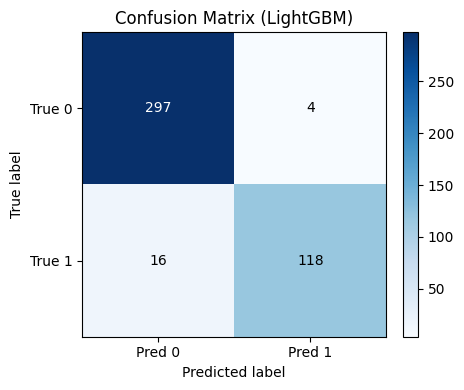

Confusion matrix plot saved to: fi_plots\cm_LightGBM.png
Summary CSV saved to: run_summaries\summary_LightGBM.csv

=== Summary of all methods ===

Method: LightGBM
  Metrics: {'AUC': 0.9794218277383844, 'ACC': 0.9540229885057471, 'Precision': 0.9672131147540983, 'Recall': 0.8805970149253731, 'F1': 0.921875}
  Num features used: 50
  Model saved at: models\lgb_model_20251211_093754.pkl
  Scaler saved at: models\scaler_20251211_093754.pkl
  Class report: models\class_report_LightGBM.txt
  FI plot: fi_plots\fi_LightGBM.png
  CM plot: fi_plots\cm_LightGBM.png
  Summary CSV: run_summaries\summary_LightGBM.csv


In [21]:
feature_methods = {
    # "RandomForest": select_rf_features,
    "LightGBM": select_lgb_features,
    # "XGBoost": select_xgb_features,
    # "ExtraTrees": select_extra_trees_features,
    # "LASSO": select_lasso_features
}

# if USE_BORUTA:
#     feature_methods["Boruta"] = select_boruta_features

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import joblib  # in case you want to load saved artifacts later

os.makedirs("fi_plots", exist_ok=True)
os.makedirs("run_summaries", exist_ok=True)

results = {}

for name, func in feature_methods.items():
    print(f"\n=== {name} Feature Selection ===")

    top_feats = func(X_full, y, TOP_N)
    if not isinstance(top_feats, (list, np.ndarray, pd.Index)):
        try:
            top_feats = list(top_feats)
        except Exception:
            top_feats = [top_feats]
    print("Top features:", top_feats)

    mapped = protein_name[protein_name["column_name"].isin(top_feats)]
    print("Mapped protein targets:", mapped["target"].to_list())

    missing = [c for c in top_feats if c not in X_full.columns]
    if missing:
        print(f"Warning: the following selected features are missing from X_full and will be dropped: {missing}")
        top_feats = [c for c in top_feats if c in X_full.columns]
    if len(top_feats) == 0:
        print("No valid features left for this method — skipping.")
        continue

    X_sel = X_full[top_feats]

    # === NEW: Save selected feature dataframe ===
    try:
        os.makedirs("selected_features", exist_ok=True)
        sel_feat_path = os.path.join("selected_features", f"selected_features_{name}.csv")
        X_sel.to_csv(sel_feat_path, index=False)
        print(f"Selected feature dataset saved to: {sel_feat_path}")
    except Exception as e:
        print(f"Could not save selected features for {name}: {e}")

    (
        metrics,
        evals_result,
        model,
        scaler,
        conf_matrix,
        class_report,
        saved_paths
    ) = train_evaluate_lgb_with_plots(X_sel, y, show_plots=True, save_model=True, out_dir="models")

    results[name] = {
        "metrics": metrics,
        "evals_result": evals_result,
        "model_obj": model,
        "scaler_obj": scaler,
        "confusion_matrix": conf_matrix,
        "classification_report": class_report,
        "saved_artifacts": saved_paths,
        "features": top_feats,
        "fi_plot": None,
        "cm_plot": None,
        "summary_csv": None,
        "selected_features_csv": sel_feat_path
    }

    results[name]["selected_features_csv"] = sel_feat_path

    # --- Feature importance (sklearn wrapper provides feature_importances_) ---
    try:
        fi_vals = model.feature_importances_
        fi_series = pd.Series(fi_vals, index=top_feats).sort_values(ascending=False)
        print(f"Top feature importances for {name}:\n", fi_series.head(10))

        # Plot horizontal bar chart of top 20 features (or fewer if not available)
        n_plot = min(20, len(fi_series))
        plt.figure(figsize=(8, max(3, 0.25 * n_plot)))
        fi_series.head(n_plot)[::-1].plot(kind="barh")
        plt.title(f"Feature importances ({name}) — top {n_plot}")
        plt.xlabel("Importance (model.feature_importances_)")
        plt.tight_layout()

        # Save plot
        fi_save_path = os.path.join("fi_plots", f"fi_{name}.png")
        plt.savefig(fi_save_path, dpi=150, bbox_inches="tight")
        plt.show()
        print(f"Feature importance plot saved to: {fi_save_path}")
        results[name]["fi_plot"] = fi_save_path

    except Exception as e:
        print(f"Could not compute/plot feature importances for {name}: {e}")

    # --- Save classification report to text file (next to model if saved) ---
    try:
        if saved_paths and "model" in saved_paths:
            base_dir = os.path.dirname(saved_paths["model"])
        else:
            base_dir = "models"
        cr_path = os.path.join(base_dir, f"class_report_{name}.txt")
        with open(cr_path, "w") as f:
            f.write(f"=== Classification Report for {name} ===\n\n")
            f.write(class_report)
            f.write("\n\n=== Confusion Matrix ===\n")
            f.write(np.array2string(conf_matrix))
        results[name]["saved_artifacts"]["class_report"] = cr_path
        print(f"Classification report saved to: {cr_path}")
    except Exception as e:
        print(f"Could not save classification report for {name}: {e}")

    # --- Save confusion-matrix figure (replot and save) ---
    try:
        cm = conf_matrix
        plt.figure(figsize=(5, 4))
        im = plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(f"Confusion Matrix ({name})")
        plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.xticks([0, 1], ["Pred 0", "Pred 1"])
        plt.yticks([0, 1], ["True 0", "True 1"])
        thresh = cm.max() / 2.0 if cm.max() != 0 else 0.5
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                         ha="center", va="center",
                         color="white" if cm[i, j] > thresh else "black")
        plt.ylabel("True label")
        plt.xlabel("Predicted label")
        plt.tight_layout()
        cm_save_path = os.path.join("fi_plots", f"cm_{name}.png")
        plt.savefig(cm_save_path, dpi=150, bbox_inches="tight")
        plt.show()
        results[name]["cm_plot"] = cm_save_path
        print(f"Confusion matrix plot saved to: {cm_save_path}")
    except Exception as e:
        print(f"Could not save confusion matrix plot for {name}: {e}")

    # --- Save a small summary CSV with metrics & meta ---
    try:
        summary_df = pd.DataFrame([{
            "method": name,
            "n_features": len(top_feats),
            **{k: v for k, v in metrics.items()}
        }])
        summary_path = os.path.join("run_summaries", f"summary_{name}.csv")
        summary_df.to_csv(summary_path, index=False)
        results[name]["summary_csv"] = summary_path
        print(f"Summary CSV saved to: {summary_path}")
    except Exception as e:
        print(f"Could not save summary CSV for {name}: {e}")

# after loop: print a compact comparison
print("\n=== Summary of all methods ===")
for k, v in results.items():
    print(f"\nMethod: {k}")
    print("  Metrics:", v["metrics"])
    print("  Num features used:", len(v["features"]))
    print("  Model saved at:", v["saved_artifacts"].get("model"))
    print("  Scaler saved at:", v["saved_artifacts"].get("scaler"))
    print("  Class report:", v["saved_artifacts"].get("class_report"))
    print("  FI plot:", v.get("fi_plot"))
    print("  CM plot:", v.get("cm_plot"))
    print("  Summary CSV:", v.get("summary_csv"))

In [ ]:
print("\n\n===== FINAL MODEL COMPARISON =====")
for m, v in results.items():
    print(f"{m}: {v}")

In [ ]:
top_feats = select_lgb_features(X_full, y, TOP_N)
mapped = protein_name[protein_name["column_name"].isin(top_feats)]

print("\nMapped protein names:")
print(mapped["target"].to_list())

In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score, recall_score, f1_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
def evaluate_simple_models(X, y):
    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Scale only for linear models
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    # Define Models
    models = {
        "RandomForest": RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1),
        "ExtraTrees": ExtraTreesClassifier(n_estimators=500, random_state=42, n_jobs=-1),
    }

    # Fit & Evaluate
    results = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Use scaled data ONLY for Logistic Regression
        if name == "LogisticRegression":
            model.fit(X_train_s, y_train)
            probs = model.predict_proba(X_test_s)[:, 1]
            preds = model.predict(X_test_s)
        else:
            model.fit(X_train, y_train)
            probs = model.predict_proba(X_test)[:, 1]
            preds = model.predict(X_test)

        # Metrics
        auc = roc_auc_score(y_test, probs)
        acc = accuracy_score(y_test, preds)
        prec = precision_score(y_test, preds, zero_division=0)
        rec = recall_score(y_test, preds)
        f1 = f1_score(y_test, preds)

        results[name] = {
            "AUC": auc,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1 Score": f1
        }

    return results


In [ ]:
results = evaluate_simple_models(df[top_feats], df['pd'])
print("\n=== Simple Model Comparison ===")
for m, vals in results.items():
    print(f"\n{m}:")
    for k, v in vals.items():
        print(f"  {k}: {v:.4f}")
